# **FRONT MATTER: Optimal Data Routing Path to Ground Station**




# **INTRODUCTION**
Routing optimization in aeronautical networks refers to the process of finding the most efficient path for aircraft to travel between two points. This involves considering factors such as fuel consumption, flight time, and weather conditions, as well as constraints such as airspace restrictions and flight schedules. The goal of routing optimization is to reduce costs and improve safety and efficiency for aircraft operators and air traffic controllers. Some common techniques used for routing optimization include mathematical programming and heuristic algorithms.
There are several techniques that can be used for optimization in aeronautical networks, including:

Mathematical Programming: This involves using mathematical models to find the optimal solution to a problem. Common methods include linear programming, mixed-integer programming, and nonlinear programming.

Heuristic Algorithms: These are methods that use trial and error to find approximate solutions to problems. Heuristic algorithms include genetic algorithms, simulated annealing, and ant colony optimization.

Artificial Intelligence (AI) and Machine Learning (ML) : AI and ML algorithms can be used to identify patterns in data and make predictions. They can be used to optimize routing by analyzing historical flight data and making predictions about future flight patterns.

Constraint Programming: This is a method of solving optimization problems by expressing the problem as a set of constraints on the variables. It can be used to find solutions that satisfy a set of constraints while minimizing or maximizing a given objective function.

Hybrid Methods: A combination of multiple optimization technique can also be used to achieve the optimal solution.

Each technique has its own advantages and disadvantages, and the choice of method will depend on the specific problem and constraints of the aeronautical network.

In this particular problem we will be using Bellman-Ford Algorithm

# **Problem Definition**

This assignment deals with a real-world problem of routing optimisation for aeronautical networks. There are thousands of airplanes flying over the North-Atlantic every day. In order to provide Internet access to passengers onboard, each airplane needs to find an optimal data packet routing path to a ground station in terms of one or two and more objectives to be optimized.

These objectives are:

1. Finding the routing paths having maximum end-to-end transmission rates to reach the nearby ground stations.

2. Finding the routing paths having minimum end-to-end latency rates and maximum end-to-end transmission rates.

# **Importing all the required libraries**

Numpy - NumPy is a Python library that is used for working with large, multi-dimensional arrays and matrices of numerical data. It provides a high-performance multidimensional array object, and tools for working with these arrays.

Pandas - Pandas is a Python library that provides tools for working with data in a fast, flexible, and expressive manner. It is designed to make it easy to work with data, whether it is structured or unstructured.

Matplotlib - Matplotlib is a Python library that  allows you to create a wide variety of static, animated, and interactive visualizations, including line plots, scatter plots, bar plots, error bars, histograms, bar charts, pie charts, box plots, and many others.

Re - The re module is a Python library that provides support for regular expressions. Regular expressions are a powerful tool for matching and manipulating strings, and are widely used in text processing and data analysis.

Math - The math module is a built-in Python library that provides math-related functions. It includes functions for basic mathematical operations, such as addition, subtraction, multiplication, and division, as well as functions for more advanced mathematical operations, such as trigonometry, logarithms, and statistical functions.

Seaborn - Seaborn is a Python library for creating statistical visualizations. It is built on top of Matplotlib and provides a high-level interface for drawing attractive and informative statistical graphics.
Seaborn is particularly useful for exploring relationships between multiple variables, and provides functions for visualizing univariate and bivariate distributions, linear relationships, and comparison of multiple groups. It also has functions for visualizing categorical data, including bar plots and box plots.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from math import radians
import math
import seaborn as sns

# Loading the dataset

In [2]:
df = pd.read_csv('D:/Submission/aashay/NA_13_Jun_29_2018_UTC13.CSV')

In [3]:
print(df.head())

  Flight No.   Timestamp  Altitude  Latitude  Longitude
0      AA101  1530277200   39000.0      50.9      -38.7
1      AA109  1530277200   33000.0      60.3      -12.2
2      AA111  1530277200   39000.0      52.7      -18.1
3      AA113  1530277200   37000.0      43.0      -11.1
4      AA151  1530277200   36400.0      47.0      -27.7


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Flight No.  216 non-null    object 
 1   Timestamp   216 non-null    int64  
 2   Altitude    216 non-null    float64
 3   Latitude    216 non-null    float64
 4   Longitude   216 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 8.6+ KB
None


#### Renaming the column names to work conveniently

In [5]:
df.rename(columns = {'Flight No.': 'flight_no', 'Timestamp': 'timestamp', \
                     'Latitude': 'latitude', 'Longitude': 'longitude', \
                     'Altitude': 'altitude'}, inplace = True)
df = df.drop(columns = {'timestamp'})

#### Converting ground stations into dataset

In [6]:
gs = pd.DataFrame({'flight_no': ['LHR', 'EWR'], 'altitude': [81.73, 8.72], 'latitude': [51.4700, 40.6895], \
                   'longitude': [0.4543, 74.1745]})
print(gs)

  flight_no  altitude  latitude  longitude
0       LHR     81.73   51.4700     0.4543
1       EWR      8.72   40.6895    74.1745


### Concatenate ground states to the dataframe
In Python, the concat() method is used to concatenate two or more strings. It is a method of the str class.

In [7]:
df_temp = pd.concat((df, gs), axis = 0)
print(df_temp.head(2))
print('..')
print(df_temp.tail(2))

  flight_no  altitude  latitude  longitude
0     AA101   39000.0      50.9      -38.7
1     AA109   33000.0      60.3      -12.2
..
  flight_no  altitude  latitude  longitude
0       LHR     81.73   51.4700     0.4543
1       EWR      8.72   40.6895    74.1745


# **METHODOLOGY**

In [8]:
def cartesian_coordinates(df):
    """
    convert latitutes, longitudes, and altitudes into cartesian coordinates.
    """
    distances = []
    for index, row in df.iterrows():
        Theta_a = row['latitude_x']
        Theta_b = row['latitude_y']
        Varphi_a = row['longitude_x']
        Varphi_b = row['longitude_y']

        # to convert altitude's feet into meter
        L_a = row['altitude_x'] * 0.3048
        L_b = row['altitude_y'] * 0.3048

        R_E = 6371000   # The radius of earth

        # The below code is to convert (altitude, latitude, longitude) to 3D Cartesian coordinates
        p_xa = (R_E + L_a) * math.cos(math.radians(Theta_a)) * math.cos(math.radians(Varphi_a))  # Eq. (15)
        p_ya = (R_E + L_a) * math.cos(math.radians(Theta_a)) * math.sin(math.radians(Varphi_a))  # Eq. (16)
        p_za = (R_E + L_a) * math.sin(math.radians(Theta_a))  

        p_xb = (R_E + L_b) * math.cos(math.radians(Theta_b)) * math.cos(math.radians(Varphi_b))  # Eq. (15)
        p_yb = (R_E + L_b) * math.cos(math.radians(Theta_b)) * math.sin(math.radians(Varphi_b))  # Eq. (16)
        p_zb = (R_E + L_b) * math.sin(math.radians(Theta_b))

        # calculate the distance between aircraft a and aircraft b
        d_ab_in_m = math.sqrt((abs(p_xa - p_xb)) ** 2 + (abs(p_ya - p_yb)) ** 2 + (abs(p_za - p_zb)) ** 2)
        d_ab_in_km = d_ab_in_m / 1000

        distances.append(d_ab_in_km)
    return distances

In [9]:
def transmissionRates(df):
    """
    Get the transmission rates according to corresponding distances.
    """
    df = df.copy()
    TransmissionRates = []
    for _, each_row in df.iterrows():
        if each_row['distances'] >= 500 and each_row['distances'] < 600:
            TransmissionRates.append(31.895)
        elif each_row['distances'] >= 400 and each_row['distances'] < 500:
            TransmissionRates.append(43.505)
        elif each_row['distances'] >= 300 and each_row['distances'] < 400:
            TransmissionRates.append(52.857)
        elif each_row['distances'] >= 190 and each_row['distances'] < 300:
            TransmissionRates.append(63.970)
        elif each_row['distances'] >= 90 and each_row['distances'] < 190:
            TransmissionRates.append(77.071)
        elif each_row['distances'] >= 35 and each_row['distances'] < 90:
            TransmissionRates.append(93.854)
        elif each_row['distances'] >= 5.56 and each_row['distances'] < 35:
            TransmissionRates.append(119.130)
        else:
            TransmissionRates.append(0)
    df = pd.concat((df, pd.DataFrame(TransmissionRates).rename(columns = {0: 'transmission_rates'})), axis = 1)

    return df

In [10]:
def cartesian_join(df):
    """
    Cartesian join on same dataframe on order to get the pairs of aeroplanes
    """
    df = df.copy()
    df1 = df2 = df.copy()

    df1['join'] = 0
    df2['join'] = 0

    df = df1.merge(df2, how = 'outer', on='join')
    df = df.drop(columns=['join'])

    return df

In [11]:
def remove_unwanted_data(df):
    """
    Remove unwanted data, that is, all the records having distance more than
    and equal to 600.
    """
    df = df.copy()
    distance = cartesian_coordinates(df)
    df = pd.concat((df, pd.DataFrame(distance).rename(columns = {0: 'distances'})), axis = 1)
    df = df[df['distances'] < 600]
    df.reset_index(drop=True, inplace=True)
    return df

In [12]:
def distancesAndTransmissionRates(df):
    """
    Store distance between two aeroplanes and transmission rates for each pair of aeroplanes
    """
    # creating copy if in case the operation fails, it won't effect the original dataframe
    df = df.copy()
    df = cartesian_join(df)
    df = remove_unwanted_data(df)
    df = transmissionRates(df)

    # select only the relevant columns. Distances containes distance between the pairs of
    # aeroplanes.
    df = df.loc[:, ['flight_no_x', 'flight_no_y', 'distances', 'transmission_rates']]
    # eliminate the rows having same source and destination
    df = df[df['flight_no_x'] != df['flight_no_y']]

    return df

In [13]:
def save_optimal_paths(opt_paths, filename):
    """
    save the optimal paths to text file.
    """
    with open(f'{filename}.txt', 'w') as f:
        for i in opt_paths:
            f.write("%s\n" % i)

In [14]:
def nodes_and_ids(df):
    """
    Create unique numerical IDs for all the flights.
    """
    df = df.copy()

    # Get all the unique flight numbers in numpy array form
    flights = df.flight_no_x.unique()
    # Convert them into separate dataframe
    flight_no = pd.DataFrame(flights)

    # rename the column  of dataframe from 0 to 'flight_name'
    flight_no.rename(columns = {0: 'flight_name'}, inplace = True)

    # create ids for all the flight numbers
    numerical_ids = list()
    for i in range(len(flights)):
        numerical_ids.append(i)

    # change the name of the column from 0 to 'node'
    numerical_ids = pd.DataFrame(numerical_ids).rename(columns = {0: 'node'})

    # merge two dataframes - numerical_ids and flight_no
    nodes = pd.concat([numerical_ids, flight_no], axis = 1)

    return nodes

In [15]:
def encode_nodes(df, nodes):
    """
    Encode the flight_no to numerical form using numerical IDs, and add them to the
    original dataset.
    """
    paths = df.copy()
    paths['node_from'] = 0
    paths['node_to'] = 0

    # encoding the source planes
    for index, row in nodes.iterrows():
        paths.loc[paths['flight_no_x'] == row['flight_name'], 'node_from'] = row['node']

    # encoding the destination planes
    for index, row in nodes.iterrows():
        paths.loc[paths['flight_no_y'] == row['flight_name'], 'node_to'] = row['node']

    # reset the indices of the dataframes
    paths = paths.reset_index(drop=True)
    nodes = nodes.reset_index(drop=True)
    return paths

# Bellman-Ford Algorithm
The Bellman-Ford algorithm is a method for finding the shortest path between a starting node and all other nodes in a weighted graph. It can also be used to detect negative cycles in a graph. The algorithm works by iteratively updating the distance estimates of all nodes in the graph, starting with the starting node and proceeding outward. The algorithm is called Bellman-Ford because it combines the concepts of Bellman's principle of optimality, which states that the optimal solution to a problem can be found by breaking it down into smaller subproblems, with Ford's method, which iteratively improves the solution.

In [16]:
def bellman_ford(nodes, edges, source_index = 0):
    """
    This is a Bellman-Ford algorithm.
    Here source_index refers to the numerical id of a plane.
    source index = 0 means it is first plane, or it is flight number
    AA101
    """
    path_lengths = {v: float('inf') for v in nodes}
    path_lengths[source_index] = 0

    paths = {v: [] for v in nodes}
    paths[source_index] = [source_index]

    for _ in range(len(nodes) - 1):
        for (u, v), w in edges.items():
            if path_lengths[u] + w < path_lengths[v]:
                path_lengths[v] = path_lengths[u] + w
                paths[v] = paths[u] + [v]
    
    # To check if the graph has any non-negative cycle
    for (u, v), w in edges.items():
        if path_lengths[u] + w < path_lengths[v]:
                path_lengths[v] = path_lengths[u] + w
                print("Graph has non-negative cycle.")
    return path_lengths, paths

In [17]:
def paths_and_transmission_rates(paths, source_plane = 0):
    """
    Get the optimal path, distance covered to reach the destination, and transmission
    rates of the optimal path.

    In this function we will call Bellman-Ford algorithm
    """
    # to store the edges and transmission rates
    edges = dict()
    transmission_rates = list()

    # assigning distance to each pair of nodes in tuple form.
    for index, row in paths.iterrows():
        edges[(row["node_from"], row["node_to"])] = row['distances']

    
    nodes = list(paths.node_from.unique())

    ############################################################################
    # Call the Bellman-Ford algorithm and get the total distance
    # covered by source to reach each vertex and get the optimal paths to reach
    # each vertex
    lengths, paths_ = bellman_ford(nodes, edges, source_plane)
    ############################################################################

    # Get the encoded value of ground station that is at the last vertex
    destination_index = list(paths_)[-1]
    # get the optimal path that is in the numerical form.
    encoded_path = paths_[destination_index]
    # get the total distance covered to reach the ground station
    distance = lengths[destination_index]
    # decode that path so that we can get flight names.
    decoded_path = [paths.flight_no_x.unique()[i] for i in encoded_path]
    # total number of flights to reach the destination
    num_of_flights = len(encoded_path)

    # get the transmission values for the optimal path
    for i in range(len(decoded_path) - 1):
        # get the source records
        flight_no_x = paths[paths['flight_no_x'] == f'{decoded_path[i]}']
        # get the destination for corresponding source records
        flight_no_y = flight_no_x[flight_no_x['flight_no_y'] == f'{decoded_path[i + 1]}']
        # we are now left with only one record, and therefore, get the transmission rate for that record
        transmission_rates.append(flight_no_y.transmission_rates.values[0])

    return decoded_path, transmission_rates, distance, num_of_flights

In [18]:
def perform_bellman_ford(paths):
    """
    This function will call paths_and_transmission_rates() function for each
    aeroplane. paths_and_transmission_rates() function contains the call to
    Bellman-Ford algorithm.
    """

    # Get all the flight ids excluding GS1 as it is not a source.
    flights_ids = paths[paths['flight_no_x'] != 'LHR'].node_from.unique()
    # list of all the optimal paths from source to destination
    optimal_path_from_source_to_destination = []
    # list of distances covered by each source to route a message to ground
    # station
    flights_distances = []
    num_of_planes = []
    for i in flights_ids:
        # get the optimal decoded path, that is, the flight numbers.
        # get the optimal transmission rates, distances
        # get the total number of planes.
        decoded_path, transmission_rates, distances, num_of_plane = paths_and_transmission_rates(paths, i)
        flights_distances.append(distances)
        num_of_planes.append(num_of_plane)
        optimal_paths = []

        # store the optimal paths and optimal transmission rates in a list. This excludes the source plane.
        for i, j in zip(decoded_path[1:], transmission_rates[:]):
            optimal_paths.append((i, j))

        # store the optimal paths for all the aeroplanes. This includes the source plane.
        optimal_path_from_source_to_destination.append([decoded_path[0], {'routing_path': optimal_paths}, {'End-to-end data rate': min(transmission_rates)}])
    return optimal_path_from_source_to_destination, flights_distances, num_of_planes

In [19]:
def visualize_optimal_transmission_rates(opt_paths):
    """
    visualize the optimal transmission rates and mean optimal transmission rate.
    """
    # to store all the transmission rates
    rates = []
    # from all the optimal paths
    for i in opt_paths:
        try:
            # extract the numerical values representing transmission rates.
            rate = re.findall(r'\d\d', str(i[1: 3]))
            # convert those numerical value to float datatype
            rate = [float(k) for k in rate]
            # measure the average optimal transmission rates
            rates.append(sum(rate)/len(rate))
        except:
            rates.append(0)

    plt.boxplot(rates);
    plt.title("Average Transmission Rates")
    plt.ylabel('Transmission Rates')
    
    plt.show()

In [20]:
def visualize_distances_and_average_rates(opt_paths, distances):
    """
    Visualise the distance covered by the planes and average rates.
    """
    rates = []
    for i in opt_paths:
        try:
            rate = re.findall(r'\d\d', str(i[1: 3]))
            rate = [float(k) for k in rate]
            rates.append(sum(rate)/len(rate))
        except:
            rates.append(0)

    plt.scatter(distances, rates)
    plt.title("Distances and Average Rates")
    plt.xlabel('Routing Distances')
    plt.ylabel('Transmission Rates')
    
    plt.show()

In [21]:
def visualize_number_of_planes(num_of_planes):
    """
    Visualize the number of planes.
    """
    plt.figure(figsize=(10,7))
    ax = sns.countplot(x = num_of_planes)
    for i in ax.patches:
        ax.annotate(f'\n{i.get_height()}', (i.get_x()+0.4, i.get_height()), ha='center', va='top', color='white', size=10)
    plt.xlabel('Number of planes including source and destination');

# **Single-Objective Optimization**

The objective of single-objective optimization is to get the maximum end-to-end transmission rates. To do that we will use a shortest distance algorithm called Bellman-Ford algorithm. We have implemented it from scratch. As we know, if the transmission rates are higher then the distance between nodes (aeroplanes) will be shorter, and therefore, we will use the shortest path algorithm to get the shortest optimal path and through that path, we will calculate the transmission rate for each pair of nodes until we reach the ground station.

In [22]:
# get distances and transmission
df = distancesAndTransmissionRates(df_temp)
print(df.head())

  flight_no_x flight_no_y   distances  transmission_rates
1       AA101        AA25  316.794734              52.857
2       AA101       AA291  502.096444              31.895
3       AA101        AA45  490.788961              43.505
4       AA101       AA717  196.703062              63.970
5       AA101       AA723  528.108344              31.895


In [23]:
nodes = nodes_and_ids(df)
paths = encode_nodes(df, nodes)

In [24]:
print(nodes.head())

   node flight_name
0     0       AA101
1     1       AA109
2     2       AA111
3     3       AA113
4     4       AA151


In [25]:
%%time
# get the optimal paths, total distance covered, and number of planes to reach the destination
optimal_paths_0 , distance_covered_0, num_of_planes_0 = perform_bellman_ford(paths)
save_optimal_paths(optimal_paths_0, 'single_objective_optimization')

CPU times: total: 1min 46s
Wall time: 1min 46s


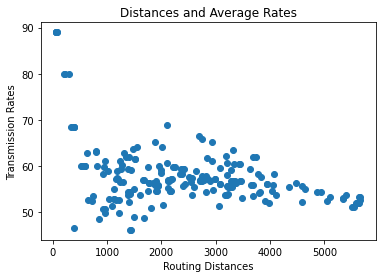

In [26]:
visualize_distances_and_average_rates(optimal_paths_0, distance_covered_0)

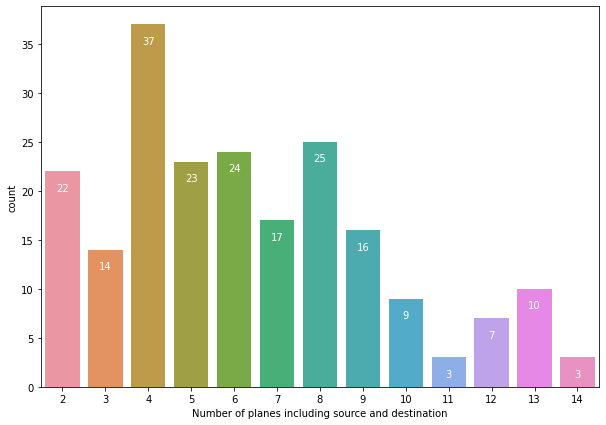

In [27]:
# x-axis is the number of planes involved to route the message to the ground station.
# y-axis represents the paths
# There are 22 paths having direct connection to the ground station, and that is why number of planes are 2, that is, source and destination.
# 14 paths having one plane as routing path to reach the ground station, and that is why, number of planes are 3.

visualize_number_of_planes(num_of_planes_0)

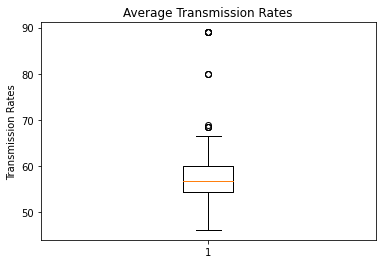

In [28]:
# This is a box plot, and red color shows mean value of all the values
visualize_optimal_transmission_rates(optimal_paths_0)

# **Multiple-Objective Optimization**
Multiple-Objective Optimization asks to maximize the end-to-end transmission rates and minimize the end-to-end latency rates. Latency rate will be decreased if the aeroplanes makes less connection with each other to route the message to the ground station. It also depends upon the distance because if two planes are at long distance, the latency rate will be increased. In Single-Objective Optimization, we have seen that some optimal paths are having 31.895 Mbps as transmission rates. To overcome this, we will decrease the distance from 500 KM switching threshold to 400 KM switching threshold. By doing that, the lowest threshold value will be 43.505 Mbps, and as the distance is reduced, the latency rate may reduce.

In [29]:
def remove_unwanted_data(df):
    """
    Remove unwanted data, that is, all the records having distance more than
    and equal to 500.
    """
    df = df.copy()
    distance = cartesian_coordinates(df)
    df = pd.concat((df, pd.DataFrame(distance).rename(columns = {0: 'distances'})), axis = 1)
    df = df[df['distances'] < 500]
    df.reset_index(drop=True, inplace=True)
    return df

In [30]:
# get distances and transmission
df = distancesAndTransmissionRates(df_temp)
print(df.head())

  flight_no_x flight_no_y   distances  transmission_rates
1       AA101        AA25  316.794734              52.857
2       AA101        AA45  490.788961              43.505
3       AA101       AA717  196.703062              63.970
4       AA101       BA175  464.631848              43.505
5       AA101       BA185  346.889472              52.857


In [31]:
nodes_1 = nodes_and_ids(df)
paths_1 = encode_nodes(df, nodes_1)

In [32]:
%%time
# get the optimal paths, total distance covered, and number of planes to reach the destination
optimal_paths_1, distance_covered_1, num_of_planes_1 = perform_bellman_ford(paths_1)
save_optimal_paths(optimal_paths_1, 'multiple_objective_optimization')

CPU times: total: 1min 26s
Wall time: 1min 26s


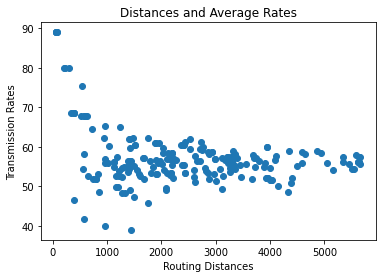

In [33]:
visualize_distances_and_average_rates(optimal_paths_1, distance_covered_1)

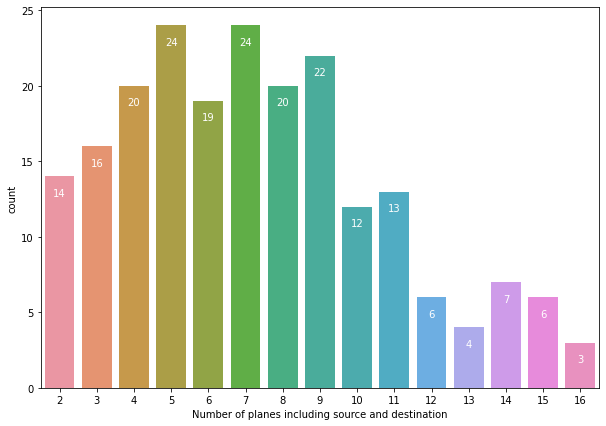

In [34]:
visualize_number_of_planes(num_of_planes_1)

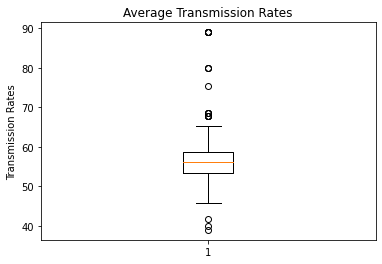

In [35]:
# This is a box plot, and red color shows mean value of all the values
visualize_optimal_transmission_rates(optimal_paths_1)

# **Experiments and Discussion**

| Optimization      | Switching Threshod Range |
| ----------------- | ------------------------ |
| Single-Objective  | 500 KM                   |
| Multiple-Objective| 400 KM                   |

| Optimization      | Planes with direct connection with ground station |
| ----------------- | ------------------------------------------------- |
| Single-Objective  | 22                                                |
| Multiple-Objective| 14                                                |

| Optimization      | Most number of aeroplanes used to route a message to ground station |
| ----------------- | ------------------------------------------------- |
| Single-Objective  | 14                                                |
| Multiple-Objective| 16                                                |

| Optimization      | Average Optimal Transmission rate |
| ----------------- | ----------------------------------|
| Single-Objective  | approx 55 Mbps                    |
| Multiple-Objective| approx 55 Mbps                    |

# **Conclusion**

In single-objective optimization, we are getting better result than multiple-objective optimization method, and this is because it has more options or paths to search for the optimal result. It uses less connectivity between planes than multiple-objective optimization method.

In multiple-objective optimization, we have decrease the switching threshold to 400 in order to check if it increases the transmission rate, but the average optimal transmission rate was same for both the cases. Maximum number of planes to route a message to ground station increased to 16.

# **Future Work**
Finding optimal route has a very rich utilization in many areas, and there are many algorithms that are formulated to get the optimal results in less time.


# **References**

Husheng Li, Chapter 2 - Basics of communications, Communications for Control in Cyber Physical Systems, Morgan Kaufmann, 2016, Page 9-30

Jean Walrand, Pravin Varaiya, CHAPTER 8 - Control of Networks, High-Performance Communication Networks (Second Edition), Morgan Kaufmann, 2000, Page 363-429

Wikipedia Contributors (2019). Bellman–Ford algorithm. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Bellman%E2%80%93Ford_algorithm.

W3Schools (n.d.). Introduction to NumPy. [online] www.w3schools.com. Available at: https://www.w3schools.com/python/numpy/numpy_intro.asp.

www.w3schools.com. (n.d.). Pandas Introduction. [online] Available at: https://www.w3schools.com/python/pandas/pandas_intro.asp#:~:text=What%20is%20Pandas%3F.

matplotlib.org. (n.d.). Pyplot tutorial — Matplotlib 3.4.2 documentation. [online] Available at: https://matplotlib.org/stable/tutorials/introductory/pyplot.html.

Python.org. (2019). Regular Expression HOWTO — Python 3.8.0 documentation. [online] Available at: https://docs.python.org/3/howto/regex.html.

seaborn.pydata.org. (n.d.). An introduction to seaborn — seaborn 0.12.0 documentation. [online] Available at: https://seaborn.pydata.org/tutorial/introduction.
